# Momento de Retroalimentación: Módulo 2 Análisis y Reporte sobre el desempeño del modelo. (Portafolio Análisis)
### Facundo Vecchi A01283666

##### Importaciones de librerias

In [204]:
# Uso General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Metricas y utilidades
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import GridSearchCV

# Modelos
from sklearn.linear_model import LogisticRegression

##### Importacion de datos y creacion de train y test dataframes

In [205]:
# Importacion de Datos

cols = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
        "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
data = pd.read_csv("wine.data", header=None, names=cols)

# Separacion de datos
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(columns="Class", axis=1))
y = data.Class.values

# Separacion de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Introduccion
En el portafolio de implementacion se intento encontrar cual seria el mejor de 8 modelos para predecir el tipo de vino del Wine dataset. El modelo que obtuvo el mejor resultado fue el de Random Forest Classifier de Sklearn. Debido a que este obtuvo un accuracy de 100% sobre el dataframe de prueba, no me hizo mucho sentido utilizarlo para este analisis ya que no estaria buscando mejorar el modelo si no que empeorarlo para ver las diferencias en la varianza y el sesgo. Por esta razon, decidi utilizar el modelo de Regression logistica de Sklearn el cual obtuvo una precision de 98%, aunque no hay mucho espacio para mejorar, el proposito de este analisis sera buscar cuales son los hiperparametros que reduzcan la varianza y el sesgo lo mas posible.

## Modelo base
Primero vamos a observar el modelo base, sin modificar ningun parametro y calcular su varianza y sesgo para determinar si este se esta ajustando correctamente al dataset.

In [206]:
lr_base = LogisticRegression()
lr_base.fit(X_train, y_train)
y_pred = lr_base.predict(X_test)
acc_base = accuracy_score(y_test, y_pred)

# la funcion bias_variance_decomp calcula la perdida promedio esperada, la varianza promedio y el sesgo promedio del modelo
# utilizando diferentes porciones de los dataframes y el modelo proporcionados
avg_e_loss_base, avg_bias_base, avg_var_base = bias_variance_decomp(lr_base, X_train, y_train, X_test, y_test, loss="0-1_loss",
                                                     num_rounds=200, random_seed=42)
results = pd.Series(data=[acc_base, avg_e_loss_base, avg_bias_base, avg_var_base],
                    index=["Precision", "Error total esperado promedio", "Sesgo promedio", "Varianza promedio"])
results


Precision                        0.981481
Error total esperado promedio    0.018426
Sesgo promedio                   0.018519
Varianza promedio                0.011852
dtype: float64

Como mencione anteriormente y se puede observar en los resultados, la regresion logistica con los parametros por defecto ya tiene una precision muy buena sobre el dataset utilizando un 70-30 split para entrenar y probar. Se puede observar tambien como tanto el sesgo como la varianza son bastante bajos. </br>
Partiendo de estos resultados se probaran entrenar el modelo con diferentes parametros para tratar de reducir tanto la varianza como el sesgo, teniendo en cuenta que estos comunmente son proporcionalmente inversos.

## Cambiando el split de entrenamiento y prueba
Antes de empezar a modificar los parametros, veremos cuanto cambia la precision del modelo, junto con el sesgo y su varianza cuando se utilizan diferentes porcentajes para dividir el dataset. </br>
Para lograr esto, se va a calcular y graficar la precision del modelo, su error total, varianza y sesgo utilizando un porcentaje de 10% a 100% de training en pasos de 10%. (En total se entrenarian 10 modelos)

In [207]:
train_scores = []
test_scores = []
e_loss_scores = []
avg_bias_scores = []
avg_var_scores = []
# Utilizando 1 (100%) provoca un error al entrenar el modelo, para aproximarse al resultado verdadero, se utiliza 0.99
n_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for n in n_values:
    # Se entran un modelo nuevo, se predice tanto el training set como el testing set y se
    # calcula el error total, sesgo y varianza, estos son guardados en listas para despues ser graficados.
    lr = LogisticRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=42)
    lr.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, lr.predict(X_train)))
    test_scores.append(accuracy_score(y_test, lr.predict(X_test)))
    avg_e_loss, avg_bias, avg_var = bias_variance_decomp(lr, X_train, y_train, X_test, y_test, loss="0-1_loss",
                                                         random_seed=42)
    e_loss_scores.append(avg_e_loss)
    avg_bias_scores.append(avg_bias)
    avg_var_scores.append(avg_var)

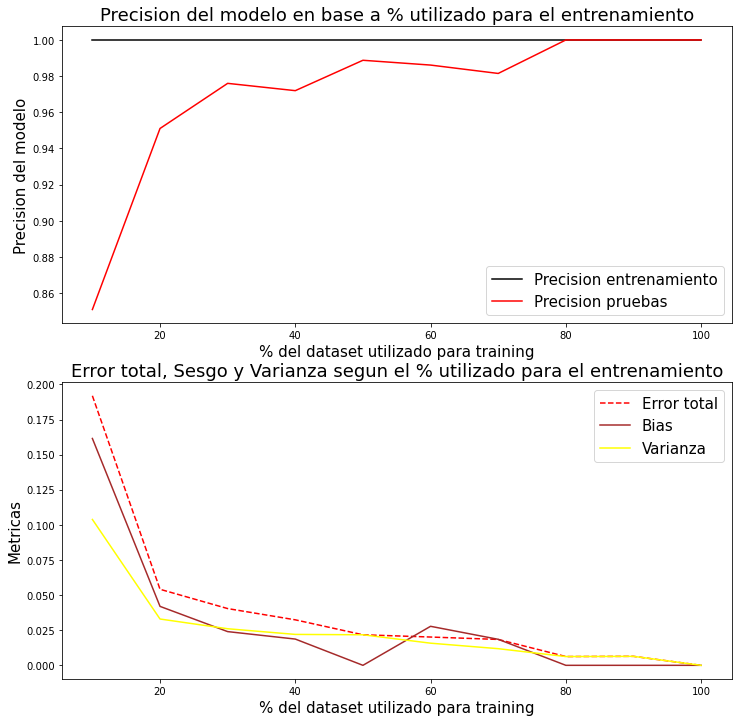

In [208]:
figure, axis = plt.subplots(2)
figure.set_size_inches(12, 12)
axis[0].plot(range(10, 110, 10), train_scores, color="black", label="Precision entrenamiento")
axis[0].plot(range(10, 110, 10), test_scores, color="r", label="Precision pruebas")
axis[0].set_title("Precision del modelo en base a % utilizado para el entrenamiento", fontsize=18)
axis[0].set_xlabel("% del dataset utilizado para training", fontsize=15)
axis[0].set_ylabel("Precision del modelo", fontsize=15)
axis[0].legend(fontsize=15)

axis[1].plot(range(10, 110, 10), e_loss_scores, "red", label="Error total", linestyle="dashed")
axis[1].plot(range(10, 110, 10), avg_bias_scores, "brown", label="Bias")
axis[1].plot(range(10, 110, 10), avg_var_scores, "yellow", label="Varianza")
axis[1].set_title("Error total, Sesgo y Varianza segun el % utilizado para el entrenamiento", fontsize=18)
axis[1].set_xlabel("% del dataset utilizado para training", fontsize=15)
axis[1].set_ylabel("Metricas", fontsize=15)
axis[1].legend(fontsize=15);

Observando estos resultados, a simple vista se puede concluir que cuanto mas porcentaje del dataset utilicemos para el entrenamiento, mejor es el modelo. En este caso, eso seria incorrecto, el data set de Wine tiene un numero de entradas muy pequeño, con tan solo 178 entradas, cuanto mas incrementamos el porcentaje de entrenamiento, menos datos tenemos con que validar el modelo. Esto signfica que, al utilizar arriba de 80% del dataset para entrenamiento, tan solo estamos utilizando 35 datos para validar, y el numero baja cada porcentaje que subamos arriba de eso. </br>
Dirigiendo la atencion hacia la grafica de error total, sesgo y varianza, podemos observar que en este caso, la precision y (el sesgo, varianza y error total) parecen ser proporcionalmente inversos. Cuando la precision sube, estas 3 metricas bajan. Lo curioso es que podemos ver una anomalia alrededor del 50%-70% de training, aqui podemos observar como la precision baja tras haber subido significativamente en el lapso anterior. Justo en ese mismo brinco, del 50% al 60% podemos observar como el sesgo sube repentinamente tambien. </br>
Aqui pueden estar pasando varias cosas:
- Realmente lo que esta pasando es que a partir del 60% de training, se empieza a tener suficientes datos para probar la verdadera precision del modelo, lo que signfica que los valores de precision obtenidos estan inflados y no son los verdaderos
- El random_state que se esta utilizando para el train_test_split causa que al utilizar algun porcentaje alrededor de 50%-70% el modelo no este siendo entrenado con los datos optimos

### Modificando el parametro de random_state
Para eliminar la posibilidad de que el random_state este causando anomalias en los resultados, se hara el mismo procedimiento pero con un random_state diferente
- En este caso se utilizara 123 en vez de 42

(No hay una razon especifica por la cual usar 123, para mantener los resultados deterministas, simplemente se tiene que asignar un random_state manualmente)

In [209]:
train_scores = []
test_scores = []
e_loss_scores = []
avg_bias_scores = []
avg_var_scores = []
# Utilizando 1 (100%) provoca un error al entrenar el modelo, para aproximarse al resultado verdadero, se utiliza 0.99
n_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for n in n_values:
    # Se entran un modelo nuevo, se predice tanto el training set como el testing set y se
    # calcula el error total, sesgo y varianza, estos son guardados en listas para despues ser graficados.
    lr = LogisticRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=123)
    lr.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, lr.predict(X_train)))
    test_scores.append(accuracy_score(y_test, lr.predict(X_test)))
    avg_e_loss, avg_bias, avg_var = bias_variance_decomp(lr, X_train, y_train, X_test, y_test, loss="0-1_loss",
                                                         random_seed=42)
    e_loss_scores.append(avg_e_loss)
    avg_bias_scores.append(avg_bias)
    avg_var_scores.append(avg_var)

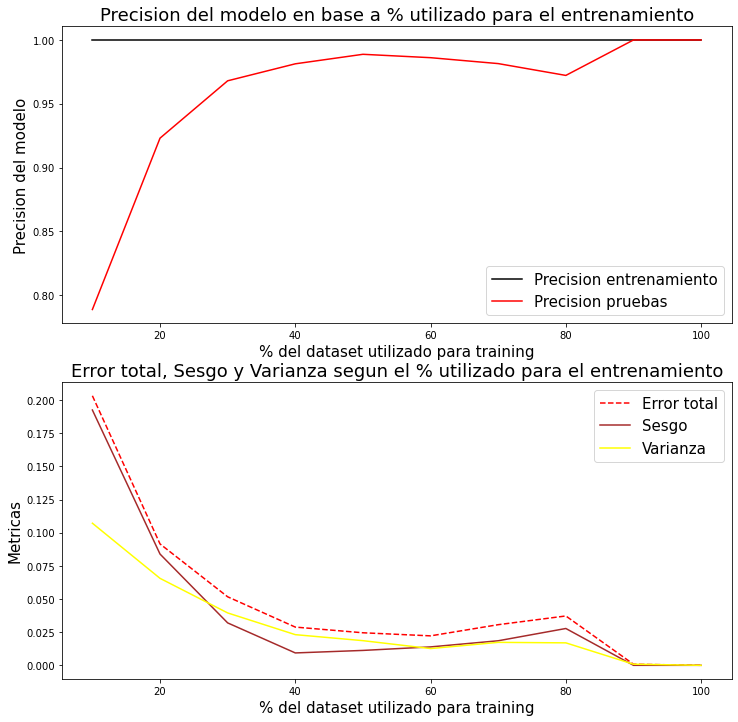

In [210]:
figure, axis = plt.subplots(2)
figure.set_size_inches(12, 12)
axis[0].plot(range(10, 110, 10), train_scores, color="black", label="Precision entrenamiento")
axis[0].plot(range(10, 110, 10), test_scores, color="r", label="Precision pruebas")
axis[0].set_title("Precision del modelo en base a % utilizado para el entrenamiento", fontsize=18)
axis[0].set_xlabel("% del dataset utilizado para training", fontsize=15)
axis[0].set_ylabel("Precision del modelo", fontsize=15)
axis[0].legend(fontsize=15)

axis[1].plot(range(10, 110, 10), e_loss_scores, "red", label="Error total", linestyle="dashed")
axis[1].plot(range(10, 110, 10), avg_bias_scores, "brown", label="Sesgo")
axis[1].plot(range(10, 110, 10), avg_var_scores, "yellow", label="Varianza")
axis[1].set_title("Error total, Sesgo y Varianza segun el % utilizado para el entrenamiento", fontsize=18)
axis[1].set_xlabel("% del dataset utilizado para training", fontsize=15)
axis[1].set_ylabel("Metricas", fontsize=15)
axis[1].legend(fontsize=15);

Sorprentemente la anomalia que apenas y era notable utilizando un random_state de 42, con un random_state de 123 se vuelve aun mas evidente. Podemos observar como alrededor del 60%, el error, el sesgo y la varianza empiezan a subir y la precision empieza a bajar. Esto signfica que podemos excluir el factor de la aleatoridad como la causa de la anomalia en estas metricas ya que aunque se vuelve mas evidente, no es exclusivo a un solo random_state, solo puede ser mas prevalente en uno que en otro. </br>
En cuanto a por que a partir del 90% la precision sube a 100% y el error, sesgo y varianza bajan a casi cero, se debe por lo mencionado anteriormente, los resultados estan inflados ya que no hay suficientes datos para probar la precision del modelo correctamente.

### Conclusiones acerca del % de entrenamiento y prueba
Debido a lo descubierto, se utilizara a partir de este punto un split de 60-40, ya que aunque la precision bajo ligeramente comparada a la del 50%, el error y varianza tambien bajaron, el sesgo y varianza tienen casi el mismo valor y el error se encuentra en lo mas bajo posible siempre y cuando se excluyan los resultados del 90% y 100%. </br>
Asimismo en las graficas se muestra claramente como en los porcentajes bajos se tiene un sesgo muy alto, indicando underfitting. Observando el otro extremo a partir del 80%, si tuvieramos mas datos para probar correctamente, la varianza probablemente empezaria a incrementar ligeramente indicando un poco de overfitting.

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

## Parametros del modelo
Ya que se sabe cual es el mejor split de entrenamiento y prueba para el dataset se empezara a probar con diferentes parametros del modelo con el proposito de reducir aun mas la varianza y el sesgo e incrementar la precision simultaneamente. </br>
Para lograr esto, vamos a concentrarnos en 4 parametros del modelo de regresion logistica de Sklearn:
- solver : Algoritmo utilizado en la optimización
- C : Inverso de la fuerza de regularización
- max_iter : Número máximo de iteraciones necesarias para que los solucionadores converjan
- penalty : Especificar la norma del penalty

Con el proposito de facilitar la busqueda de estos parametros, se hara uso de un GridSearchCV para encontrar la mejor combinacion de parametros

In [212]:
params = {
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "C": np.logspace(-4, 4, 20),
    "max_iter": [100, 1000, 2500, 5000],
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "verbose": [0] # Silencia warnings, no afecta al rendimiento del modelo
}

lr = LogisticRegression()
warnings.filterwarnings("ignore")
clf = GridSearchCV(lr, param_grid=params, cv=3)

best_model = clf.fit(X_train, y_train)

In [213]:
print("Mejores parametros:", best_model.best_params_)

Mejores parametros: {'C': 0.00026366508987303583, 'max_iter': 100, 'penalty': 'none', 'solver': 'sag', 'verbose': 0}


Tras correr el GridSearchCV, este nos indica que, de los parametros que le dimos para probar, la mejor combinacion es la siguiente:
- solver : newton-cg
- C : 0.08858667904100823
- max_iter : 100
- penalty : l2

Utilizando estos parametros para sacar la precision, ya podemos observar que hubo un ligero aumento en comparacion a la precision inicial del modelo base.

## Resultados y Conclusiones
Tras obtener los supuestos mejores parametros para el modelo, se realizara una comparativa con el modelo base con el que empezamos

In [214]:
lr_new = LogisticRegression(C=0.08858667904100823, max_iter=100, penalty="l2", solver="newton-cg")
lr_new.fit(X_train, y_train)

LogisticRegression(C=0.08858667904100823, solver='newton-cg')

In [215]:
accuracies = ["Precision", acc_base, accuracy_score(y_test, lr_new.predict(X_test))]

avg_e_loss_new, avg_bias_new, avg_var_new = bias_variance_decomp(lr_new, X_train, y_train, X_test, y_test, loss="0-1_loss",
                                                                 num_rounds=200, random_seed=42)
errors = ["Error total esperado promedio", avg_e_loss_base, avg_e_loss_new]
biases = ["Sesgo promedio", avg_bias_base, avg_bias_new]
variances = ["Varianza promedio", avg_var_base, avg_var_new]

results = pd.DataFrame(data=[accuracies, errors, biases, variances], columns=["","base", "nuevo"])
results


,,base,nuevo
0,Precision,0.981481,0.986111
1,Error total esperado promedio,0.018426,0.021944
2,Sesgo promedio,0.018519,0.013889
3,Varianza promedio,0.011852,0.014444


Como se puede observar, se logro una ligera mejora en la precision, subio alrededor de un 0.5%, como se menciono al inicio del analisis, el modelo ya tiene una precision bastante alta y dificilmente se iba a lograr una mejora signficativa. Sin embargo, cabe mencionar que aun que se obtuvo una mayor precision sobre los datos de prueba y el sesgo haya bajado, el error total esperado subio, y la varianza tambien. Siguen estando signficativamente bajos, lo que no perjudicara tanto al rendimiento del modelo, pero para los propositos de este analisis, se puede considerar como un ligero sacrificio el incremento en el error y la varianza para obtener mejor precision dependiendo del caso.